In [119]:
from multiprocessing.pool import mapstar

import sympy as sp
import numpy as np
from scipy.optimize import minimize, least_squares
from concurrent.futures.thread import ThreadPoolExecutor
import matplotlib.pyplot as plt
import pickle
from datetime import datetime

In [120]:
def truss_stiffness_matrix(nodes, elements, EA, supports):
    """
    Assemble the global stiffness matrix for a 2D truss using sympy.

    Parameters:
        nodes (dict): Dictionary of node coordinates {node_id: (x, y)}
        elements (list): List of tuples (node1, node2) defining element connectivity
        A (dict): Dictionary of cross-sectional areas {element_id: A_value}
        E (dict): Dictionary of Young's modulus values {element_id: E_value}

    Returns:
        sympy.Matrix: Global stiffness matrix
    """
    num_nodes = len(nodes)
    dof = 2 * num_nodes  # Degrees of freedom (2 per node)
    K_global = sp.zeros(dof, dof)

    for i, (n1, n2) in enumerate(elements):
        x1, y1 = nodes[n1]
        x2, y2 = nodes[n2]
        L = sp.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)  # Element length
        c = (x2 - x1) / L  # Cosine of angle
        s = (y2 - y1) / L  # Sine of angle

        # Stiffness matrix for an element in local coordinates
        k_local = (EA[i] / L) * sp.Matrix([
            [c ** 2, c * s, -c ** 2, -c * s],
            [c * s, s ** 2, -c * s, -s ** 2],
            [-c ** 2, -c * s, c ** 2, c * s],
            [-c * s, -s ** 2, c * s, s ** 2]
        ])

        # Global DOF indices
        dof_indices = [2 * n1, 2 * n1 + 1, 2 * n2, 2 * n2 + 1]

        # Assemble into global stiffness matrix
        for r in range(4):
            for c in range(4):
                K_global[dof_indices[r], dof_indices[c]] += k_local[r, c]

        for i in supports:
            for j in range(K_global.shape[0]):
                K_global[i, j] = 0.
                K_global[j, i] = 0.
            K_global[i, i] = 1

    return K_global


# Nodes
def coordinates(n_panels, l, h):
    nodes = []
    for idx in range(n_panels + 1):
        x = idx * l
        nodes.append([x, 0.])
    for idx in range(n_panels + 1, 2 * n_panels):
        x = n_panels * l - l * (idx - n_panels)
        nodes.append([x, h])
    return nodes


def connectivity(n_panels):
    idx_bar = 0
    # Horizontal Elements
    elements = []
    for idx in range(n_panels):
        idx_start = idx
        idx_end = idx_start + 1
        elements.append([idx_start, idx_end])
        idx_bar += 1

    for idx in range(n_panels + 1, 2 * n_panels - 1):
        idx_start = idx
        idx_end = idx_start + 1
        elements.append([idx_start, idx_end])
        idx_bar += 1

    # Vertical Elements
    for idx in range(1, n_panels):
        idx_start = idx
        idx_end = 2 * n_panels - idx_start
        elements.append([idx_start, idx_end])
        idx_bar += 1

    # Diagonal Elements

    elements.append([0, 2 * n_panels - 1])
    idx_bar += 1

    for idx in range(1, n_panels // 2):
        idx_start = idx + 1
        idx_end = 2 * n_panels + 1 - idx_start
        elements.append([idx_start, idx_end])
        idx_bar += 1

    for idx in range(n_panels // 2, n_panels - 1):
        idx_start = idx
        idx_end = 2 * n_panels - 1 - idx_start
        elements.append([idx_start, idx_end])
        idx_bar += 1

    elements.append([n_panels, n_panels + 1])
    idx_bar += 1

    return elements

In [121]:
# Symbolic formulation
h = sp.Symbol('H', real=True, positive=True)
l = sp.Symbol('L', real=True, positive=True)

n_panels = 8
nodes = coordinates(n_panels, l, h)
elements = connectivity(n_panels)

EA = [sp.Symbol(f'EA{i:02d}', real=True, positive=True) for i in range(len(elements))]

K_sym = truss_stiffness_matrix(nodes, elements, EA, (0, 1, 17)).subs({h: 7.5, l: 7.5})
K_f = sp.lambdify(EA, K_sym, modules='numpy')

In [122]:
# Providing actual example solving Ku-q = 0
np.random.seed(2)
EA_values = np.random.uniform(150e9, 250e9, size=29) * (0.1 * 0.1)

q = np.zeros(2 * len(nodes))
q[7] = -1000e3
K_ref = np.array(K_sym.subs({EA_i: EA_values[i] for i, EA_i in enumerate(EA)})).astype(float)
u = np.linalg.solve(K_ref, q)

In [123]:
from scipy.optimize import minimize
import numpy as np


# Use numerical u, q, nodes, elements from before

def make_K(EA_vals):
    subs_dict = {EA[i]: EA_vals[i] for i in range(len(EA))}
    K_num = K_f(*EA_vals)
    return np.array(K_num).astype(np.float64)


def residual(EA_vals):
    K_est = make_K(EA_vals)
    return K_est @ u - q


def objective(EA_vals):
    r = residual(EA_vals)
    return np.linalg.norm(r) ** 2


# Initial guess
EA_guess = np.full(len(EA), np.random.uniform(1e9, 2.5e9, size=EA_values.shape))

res = minimize(objective, EA_guess, method='L-BFGS-B', bounds=[(1e8, 1e10)] * len(EA))
EA_estimated = res.x

In [129]:
for i, u in enumerate(np.round(np.abs((EA_estimated - EA_values) / EA_values), 3)):
    if u != 0.:
        print(i)

14
17
20


In [26]:
K_ref @ u

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        4.65661287e-10,  1.39698386e-09, -1.86264515e-09, -1.86264515e-09,
        2.79396772e-09, -1.00000000e+06, -2.32830644e-10, -2.79396772e-09,
       -4.65661287e-10,  3.25962901e-09,  1.86264515e-09,  0.00000000e+00,
       -9.31322575e-10,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        1.16415322e-09, -4.65661287e-09,  1.39698386e-09,  7.68341124e-09,
        0.00000000e+00, -3.72529030e-09, -5.58793545e-09,  2.09547579e-09,
        2.79396772e-09, -2.79396772e-09,  0.00000000e+00,  9.31322575e-10])

In [36]:
K_sym

Matrix([
[1, 0,                                               0,                       0,                                                                         0,                                                0,                                                                         0,                                                0,                                                                                                   0,                                                                          0,                                                                         0,                                                0,                                                                         0,                                                0,                                               0,                       0,                                                0, 0,                                                                          0,                               

In [10]:
def noisy_routine(K_f, u, q):
    def make_K(EA_vals):
        K_num = K_f(*EA_vals)
        return np.array(K_num).astype(np.float64)

    def residual(EA_vals):
        K_est = make_K(EA_vals)
        return K_est @ u - q

    def objective(EA_vals):
        r = residual(EA_vals)
        return np.linalg.norm(r) ** 2

    # Initial guess
    EA_guess = np.full(len(EA), np.min(EA_values))

    res = least_squares(
        residual,
        EA_guess,
        bounds=[1e9, 3e9],
        method='trf',
        loss='huber',
        f_scale=1e4,
        max_nfev=250,
        xtol=1e-6,
        ftol=1e-6,
        gtol=1e-6,
    )

    return res.x


f_values = np.linspace(0, .05, 6) / 2
xs = {f: [] for f in f_values}
xs['EA_values'] = EA_values

sample_size = 10
with ThreadPoolExecutor(max_workers=10) as thread_pool:
    for f in f_values:
        threads = []
        for i in range(sample_size):
            u_noisy = u * (np.random.normal(1, f, size=u.shape))
            q_noisy = q * (np.random.normal(1, f, size=q.shape))
            thread = thread_pool.submit(
                lambda f, u, q: xs[f].append(noisy_routine(K_f, u, q)),
                f, u_noisy, q_noisy)
            threads.append(thread)

        sample_done = False
        count = -1
        while not sample_done:
            old_count = count
            dones = [thread.done() for thread in threads]
            dones_count = int(np.sum(dones))
            sample_done = bool(np.all(dones))

with open(f'analytical_results_{datetime.now().strftime("%y%m%d_%H%M")}.pkl', 'wb') as f:
    pickle.dump(xs, f)

In [138]:
#with open(f'analytical_results_250529_1305.pkl', 'rb') as f:
#    xs = pickle.load(f)

EA_values = xs['EA_values']
keys = set(xs.keys())
keys.remove('EA_values')
x = np.array(sorted(keys)) * 400

mapes = np.array([np.abs((xs[f] - EA_values) / EA_values) for f in keys])
mapes = np.delete(mapes, [14, 17, 20], axis=2)

mean_mape = np.array([np.mean(mape) for mape in mapes])

std_mape = np.array([np.std(mape) for mape in mapes])

ic_mape = {q: np.array([np.quantile(mape, q) for mape in mapes]) for q in [.025, .975]}

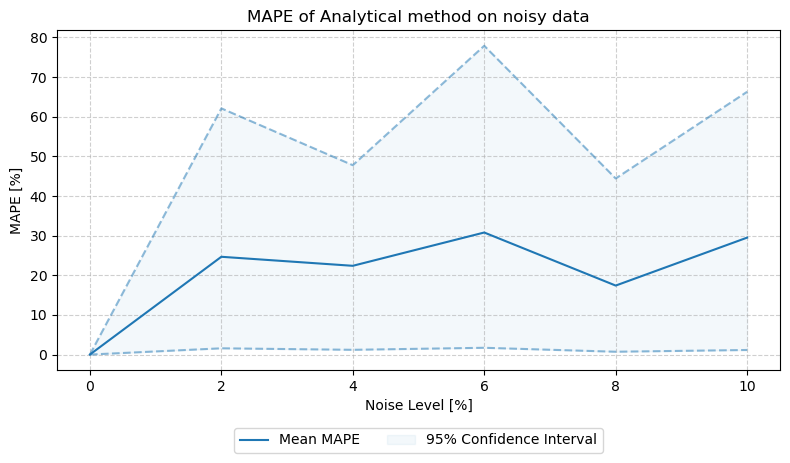

In [139]:
fig, ax = plt.subplots(figsize=(8, 5))

# Plot mean MAPE
ax.plot(x, 100 * mean_mape, label="Mean MAPE", color="C0")
for i, q_i in enumerate(ic_mape.keys()):
    ax.plot(x, 100 * ic_mape[q_i], color="C0", linestyle='--', alpha=.5)

# Fill confidence interval
ax.fill_between(x, 100 * ic_mape[0.025], 100 * ic_mape[0.975], color="C0", alpha=0.05, label="95% Confidence Interval")

# Axis labels and title
ax.set_xlabel("Noise Level [%]")
ax.set_ylabel("MAPE [%]")
ax.set_title("MAPE of Analytical method on noisy data")

# Grid
ax.grid(True, linestyle="--", alpha=0.6)

# Legend below the plot
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)

plt.tight_layout()
plt.subplots_adjust(bottom=0.25)
plt.show()

In [14]:
xs[0.] - EA_values

array([[-2.38418579e-06, -2.38418579e-06,  3.09944153e-06,
         1.66893005e-06,  2.86102295e-06,  2.62260437e-06,
        -1.14440918e-05, -8.10623169e-06,  3.33786011e-06,
         7.39097595e-06,  4.29153442e-06,  4.29153442e-06,
         5.00679016e-06,  8.10623169e-06, -8.97113974e+06,
         1.04904175e-05,  1.62124634e-05, -5.58371613e+08,
         2.33650208e-05,  9.77516174e-06, -8.00709518e+08,
         1.04904175e-05,  4.05311584e-06,  3.33786011e-06,
        -1.81198120e-05, -2.09808350e-05,  1.19209290e-06,
         3.09944153e-06, -1.14440918e-05],
       [-2.38418579e-06, -2.38418579e-06,  3.09944153e-06,
         1.66893005e-06,  2.86102295e-06,  2.62260437e-06,
        -1.14440918e-05, -8.10623169e-06,  3.33786011e-06,
         7.39097595e-06,  4.29153442e-06,  4.29153442e-06,
         5.00679016e-06,  8.10623169e-06, -8.97113974e+06,
         1.04904175e-05,  1.62124634e-05, -5.58371613e+08,
         2.33650208e-05,  9.77516174e-06, -8.00709518e+08,
         1.04